# Test Set

In [507]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [508]:
amazon = pd.read_csv('amazon_data/raw_data_test.csv')
print(amazon.shape)

(91000, 14)


In [509]:
print(amazon.loc[0, "Text"])

I don't know what effects I will experience, however, it tastes good.  It arrived promptly, and I received two 32 ounce jars.  I add it  to my coffee each morning, and it gives the coffee a very nice rich flavor.  I use it on my arms, my legs, my feet.  It makes my skin soft, and in particular, my feet feels less dry even after just one application.  I think it is better then the moisturing lotions you find in the stores.  Amazing, that you can eat this stuff and use it for skincare too.


In [510]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0       64452        161015  161016  B003OGKCDC   A2HWU6AF8SCYZ   
1      159220        172087  172088  B000MQ60LK  A2VK8EU7NT8II6   
2      203623         54199   54200  B000PIX39M  A2HDJ8C53PNI1V   
3      306510        406629  406630  B004IOVWN8  A2W9I628I6SE1U   
4      185974        123605  123606  B001QXZ7QC  A2H2GBPQLTRLNU   

                                  ProfileName  HelpfulnessNumerator  \
0                                     Lee lee                     1   
1                                     D. Shaw                     1   
2                                    C. Price                     1   
3  Kort "Art, Music, Book & Movie Enthusiast"                     2   
4                          Health Warrior Ken                     4   

   HelpfulnessDenominator  Score        Time  \
0                       1      4  1338854400   
1                       1      5  1205107200   
2                       1 

### Feature extraction on natural language data

In [511]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [512]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 1048576)


In [513]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [514]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [515]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Summary", "reviewLen"]]
print(X_quant_features.head(100))
print(type(X_quant_features))

                                              Summary  reviewLen
0   Efagold Organic coconut oil, 32 ounce jar - go...        492
1                                       Wonderful tea        116
2                        Tastes Good, Hidden Surprise        625
3                                        That's Nuts!       2417
4           Eden is the best canned food you can get!        326
5                                      Waste of money        155
6                                 Keurig jet fuel pod        238
7                         Eclipse Mints are the best!       1829
8                                  Actually Very Good        233
9                                                Like        549
10                    Best Kombucha kit on the market        525
11                                     Sweet but good        204
12                                           The Best        527
13                                    good endoscopy!        640
14                       

### Combine all quantitative features into a single sparse matrix

In [516]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

TypeError: no supported conversion for types: (dtype('O'),)

### Create `X`, scaled matrix of features

In [ ]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

### create `y`, vector of Labels

In [ ]:
y = amazon['helpful'].values
print(type(y))

### predict `y` with the fit on the training set

In [517]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6648, 'Neg': 84352, 'TP': 2497, 'TN': 72991, 'FP': 11361, 'FN': 4151, 'Accuracy': 0.8295384615384616, 'Precision': 0.18018473084139125, 'Recall': 0.3756016847172082, 'desc': 'nbs'}


### ROC plot to compare performance of various models and fits

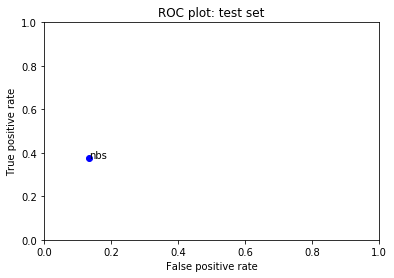

In [518]:
fits = [nbs_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [ ]:
amazon.loc[0, "Text"]

In [ ]:
amazon.loc[0, "helpful"]

In [ ]:
ridge_predictions.shape

In [ ]:
print(ridge_predictions)

In [ ]:
# false positives

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')